In [42]:
import sys
sys.path.append('../')

from quantumsim import *
from pennylane import numpy as np
import matplotlib.pyplot as plt


def FHExacto(params):
    qubits = params["sites"]*2
    hopping = -params["hopping"]
    potential = params["potential"]
    fermi_sentence = 0.0

    if params["sites"] == 1:
        fermi_sentence +=  potential*FermiC(0)*FermiA(0)*FermiC(1)*FermiA(1)
    else:
        for i in range(params["sites"]-1):
            fermi_sentence +=  hopping*FermiC(2*i)*FermiA(2*i +2) + hopping*FermiC(2*i +2)*FermiA(2*i)
            fermi_sentence +=  hopping*FermiC(2*i+1)*FermiA(2*i +3) + hopping*FermiC(2*i +3)*FermiA(2*i +1)  
            fermi_sentence +=  potential*FermiC(2*i)*FermiA(2*i)*FermiC(2*i +1)*FermiA(2*i +1)

        if params["pattern"] == "close" and params["sites"] != 2:
            qsite = 2*(params["sites"]-1)
            fermi_sentence +=  hopping*FermiC(0)*FermiA(qsite) + hopping*FermiC(qsite)*FermiA(0)
            fermi_sentence +=  hopping*FermiC(1)*FermiA(qsite+1) + hopping*FermiC(qsite+1)*FermiA(1) 

    h = qml.jordan_wigner( fermi_sentence, ps=True).to_mat(wire_order=[i for i in range(qubits)])
    return np.sort( np.linalg.eigvals(h) )

In [58]:
shape = qml.kUpCCGSD.shape(k=1, n_wires=4, delta_sz=0)
print(shape)

(1, 6)


In [57]:
singles, doubles = qml.qchem.excitations(2, 4)

# Map excitations to the wires the UCCSD circuit will act on
s_wires, d_wires = qml.qchem.excitations_to_wires(singles, doubles)
len(singles) + len(doubles)

3

### Exacto

In [19]:
params = {
    "sites": 3,
    "hopping": -1, 
    "potential": 2,
    "pattern": "open"
}
ee1 = FHExacto(params)

params = {
    "sites": 3,
    "hopping": -1, 
    "potential": 2,
    "pattern": "close"
}
ee2 = FHExacto(params)

### VQE

In [43]:
params = {
    "sites": 3,
    "hopping": -1, 
    "potential": 2,
    "pattern": "open"
}

hubbard_chain = vqe_fermihubbard(params)
hubbard_chain.set_group_characteristics()

In [44]:
ansatz_params = {
    "repetitions": 1,
    "base": "default.qubit",
    "backend": None,
    "interface": "autograd",
    "shots": 1000.0,
    "token": None,
    "pattern": "chain"
}

hubbard_chain.set_device(ansatz_params)
hubbard_chain.set_node(ansatz_params)
hubbard_chain.set_state( 3 )
a,b = qml.kUpCCGSD.shape(k=ansatz_params["repetitions"], n_wires=hubbard_chain.qubits, delta_sz=0)

In [45]:
minimizate_params = {
    "type": "SLSQP",
    "maxiter": 50,
    "tol": 0.000001,
    "number": a*b,
    "theta":["adam", 0.25]}

#optimizer = scipy_optimizer(minimizate_params)
#optimizer.set_constrains()

optimizer = gradiend_optimizer(minimizate_params)
energy, optimum = optimizer.VQE(hubbard_chain.cost_function)

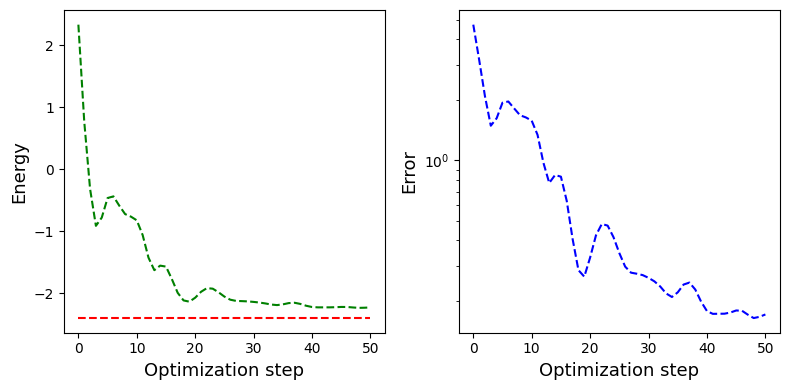

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)

ax[0].plot([i for i in range(len(energy))], energy, "g", ls="dashed")
ax[0].plot([i for i in range(len(energy))], [ee1[0] for i in range(len(energy))], "r", ls="dashed")

ax[1].plot([i for i in range(len(energy))], [np.abs(energy[i] -ee1[0]) for i in range(len(energy))], "b", ls="dashed")
ax[1].set_yscale("log")
fig.tight_layout()
plt.show()

In [47]:
params = {
    "sites": 3,
    "hopping": -1, 
    "potential": 2,
    "pattern": "close"
}

hubbard_chain = vqe_fermihubbard(params)
hubbard_chain.set_group_characteristics()

In [48]:
ansatz_params = {
    "repetitions": 1,
    "base": "default.qubit",
    "backend": None,
    "interface": "autograd",
    "shots": 1000.0,
    "token": None,
    "pattern": "chain"
}

hubbard_chain.set_device(ansatz_params)
hubbard_chain.set_node(ansatz_params)
hubbard_chain.set_state( 3 )
a,b = qml.kUpCCGSD.shape(k=ansatz_params["repetitions"], n_wires=hubbard_chain.qubits, delta_sz=0)

In [49]:
minimizate_params = {
    "type": "SLSQP",
    "maxiter": 50,
    "tol": 0.000001,
    "number": a*b,
    "theta":["adam", 0.25]}

optimizer = gradiend_optimizer(minimizate_params)
energy, optimum = optimizer.VQE(hubbard_chain.cost_function)

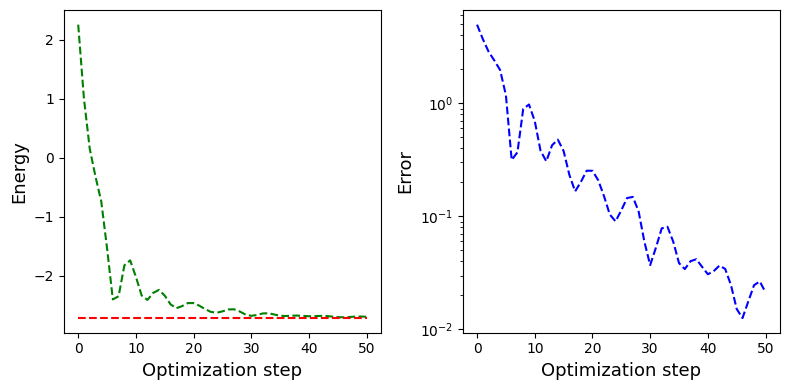

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)

ax[0].plot([i for i in range(len(energy))], energy, "g", ls="dashed")
ax[0].plot([i for i in range(len(energy))], [ee2[0] for i in range(len(energy))], "r", ls="dashed")

ax[1].plot([i for i in range(len(energy))], [np.abs(energy[i] -ee2[0]) for i in range(len(energy))], "b", ls="dashed")
ax[1].set_yscale("log")
fig.tight_layout()
plt.show()